# Imports

In [29]:
import time
import fasttext
import math
import random
import collections
import warnings
import requests
import numpy as np
import pandas as pd
import matplotlib.cm as cm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.nn import functional as F

from hmmlearn import hmm
from scipy.sparse import dok_matrix

from torchtext import data, datasets
from torchtext.vocab import FastText

import nltk
from nltk import FreqDist
from nltk.corpus import brown
from nltk.tokenize import word_tokenize

from gensim.models import Word2Vec

from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder

from tqdm import tqdm_notebook as tqdm
from d2l import torch as d2l

# Helper Functions

In [2]:
warnings.simplefilter("ignore")
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('brown')
nltk.download('webtext')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/zachary.sheldon/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/zachary.sheldon/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package brown to
[nltk_data]     /Users/zachary.sheldon/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package webtext to
[nltk_data]     /Users/zachary.sheldon/nltk_data...
[nltk_data]   Package webtext is already up-to-date!


True

In [6]:
def cosine_similarity(vec_a, vec_b):
    """Compute cosine similarity between vec_a and vec_b"""
    return np.dot(vec_a, vec_b) / (np.linalg.norm(vec_a) * np.linalg.norm(vec_b))

def tokenize(sentences):
    #Tokenize the sentence
    #from nltk.tokenize library use word_tokenize
    token = word_tokenize(sentences)
    return token


def plot_train_val(x, train, val, train_label, val_label, title, y_label,
                   color):
    plt.plot(x, train, label=train_label, color=color)
    plt.plot(x, val, label=val_label, color=color, linestyle='--')
    plt.legend(loc='lower right')
    plt.xlabel('epoch')
    plt.ylabel(y_label)
    plt.title(title)


def load_dataset(emb_vectors, sentence_length=50, seed=522):
    TEXT = data.Field(sequential=True,
                    tokenize=tokenize,
                    lower=True,
                    include_lengths=True,
                    batch_first=True,
                    fix_length=sentence_length)
    LABEL = data.LabelField(dtype=torch.float)

    train_data, test_data = datasets.IMDB.splits(TEXT, LABEL)

    TEXT.build_vocab(train_data, vectors=emb_vectors)
    LABEL.build_vocab(train_data)

    train_data, valid_data = train_data.split(split_ratio=0.7,
                                            random_state=random.seed(seed))
    train_iter, valid_iter, test_iter = data.BucketIterator.splits((train_data,
                                                                  valid_data,
                                                                  test_data),
                                                                  batch_size=32,
                                                                  sort_key=lambda x: len(x.text),
                                                                  repeat=False,
                                                                  shuffle=True)
    vocab_size = len(TEXT.vocab)

    print(f'Data are loaded. sentence length: {sentence_length} '
        f'seed: {seed}')

    return TEXT, vocab_size, train_iter, valid_iter, test_iter


def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params={ 'id': id }, stream=True)
    token = get_confirm_token(response)

    if token:
        params = { 'id': id, 'confirm': token }
        response = session.get(URL, params=params, stream=True)

    save_response_content(response, destination)


def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value

    return None


def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)
                
# @title Helper functions

def plot_train_val(x, train, val, train_label,
                   val_label, title, y_label,
                   color):

    plt.plot(x, train, label=train_label, color=color)
    plt.plot(x, val, label=val_label, color=color, linestyle='--')
    plt.legend(loc='lower right')
    plt.xlabel('epoch')
    plt.ylabel(y_label)
    plt.title(title)


def count_parameters(model):
    parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return parameters


def init_weights(m):
    if type(m) in (nn.Linear, nn.Conv1d):
        nn.init.xavier_uniform_(m.weight)


#  Dataset Loader
def load_dataset(sentence_length=50, batch_size=32, seed=522):

    TEXT = data.Field(sequential=True,
                    tokenize=nltk.word_tokenize,
                    lower=True,
                    include_lengths=True,
                    batch_first=True,
                    fix_length=sentence_length)
    LABEL = data.LabelField(dtype=torch.float)

    train_data, test_data = datasets.IMDB.splits(TEXT, LABEL)

    # If no specific vector embeddings are specified,
    # Torchtext initializes random vector embeddings
    # which would get updated during training through backpropagation.
    TEXT.build_vocab(train_data)
    LABEL.build_vocab(train_data)

    train_data, valid_data = train_data.split(split_ratio=0.7,
                                            random_state=random.seed(seed))
    train_iter, valid_iter, test_iter = data.BucketIterator.splits((train_data, valid_data, test_data),
                                                                  batch_size=batch_size, sort_key=lambda x: len(x.text),
                                                                  repeat=False, shuffle=True)
    vocab_size = len(TEXT.vocab)

    print(f"Data loading is completed. Sentence length: {sentence_length}, "
        f"Batch size: {batch_size}, and seed: {seed}")

    return TEXT, vocab_size, train_iter, valid_iter, test_iter


def text_from_dict(arr, dictionary):
    text = []
    for element in arr:
        text.append(dictionary[element])
    return text


def view_data(TEXT, train_iter):
    for idx, batch in enumerate(train_iter):
        text = batch.text[0]
        target = batch.label

        for itr in range(25, 30):
            print('Review: ', ' '.join(text_from_dict(text[itr], TEXT.vocab.itos)))
            print('Label: ', int(target[itr].item()), '\n')

        print('[0: Negative Review, 1: Positive Review]')
        if idx==0:
            break


# Training function
def train(model, device, train_iter, valid_iter, epochs, learning_rate):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    train_loss, validation_loss = [], []
    train_acc, validation_acc = [], []

    for epoch in range(epochs):
        #train
        model.train()
        running_loss = 0.
        correct, total = 0, 0
        steps = 0

        for idx, batch in enumerate(train_iter):
            text = batch.text[0]
            # print(type(text), text.shape)
            target = batch.label
            target = torch.autograd.Variable(target).long()
            text, target = text.to(device), target.to(device)

            # add micro for coding training loop
            optimizer.zero_grad()
            output = model(text)

            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            steps += 1
            running_loss += loss.item()

            # get accuracy
            _, predicted = torch.max(output, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

        train_loss.append(running_loss/len(train_iter))
        train_acc.append(correct/total)

        print(f'Epoch: {epoch + 1}, '
              f'Training Loss: {running_loss/len(train_iter):.4f}, '
              f'Training Accuracy: {100*correct/total: .2f}%')

        # evaluate on validation data
        model.eval()
        running_loss = 0.
        correct, total = 0, 0

        with torch.no_grad():
            for idx, batch in enumerate(valid_iter):
                text = batch.text[0]
                target = batch.label
                target = torch.autograd.Variable(target).long()
                text, target = text.to(device), target.to(device)

                optimizer.zero_grad()
                output = model(text)

                loss = criterion(output, target)
                running_loss += loss.item()

                # get accuracy
                _, predicted = torch.max(output, 1)
                total += target.size(0)
                correct += (predicted == target).sum().item()

        validation_loss.append(running_loss/len(valid_iter))
        validation_acc.append(correct/total)

        print (f'Validation Loss: {running_loss/len(valid_iter):.4f}, '
               f'Validation Accuracy: {100*correct/total: .2f}%')

    return train_loss, train_acc, validation_loss, validation_acc


# Testing function
def test(model, device, test_iter):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for idx, batch in enumerate(test_iter):
            text = batch.text[0]
            target = batch.label
            target = torch.autograd.Variable(target).long()
            text, target = text.to(device), target.to(device)

            outputs = model(text)
            _, predicted = torch.max(outputs, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

        acc = 100 * correct / total
    return acc
                
def set_seed(seed=None, seed_torch=True):
    if seed is None:
        seed = np.random.choice(2 ** 32)
    random.seed(seed)
    np.random.seed(seed)
    if seed_torch:
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True

    print(f'Random seed {seed} has been set.')

# In case that `DataLoader` is used
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)
    
def set_device():
    device = "cuda" if torch.cuda.is_available() else "cpu"
    return device

DEVICE = set_device()
SEED = 2021
set_seed(seed=SEED)

Random seed 2021 has been set.


# Sequences, Markov Chains, and HMMs

## Prepare the data

In [13]:
category = ['editorial', 'fiction', 'government', 'news', 'religion']
sentences = brown.sents(categories=category)

lengths = [len(sentence) for sentence in sentences]
lengths = pd.Series(lengths)

corpus_words = []
for sentence in sentences:
    for word in sentence:
        if "''" not in word and "``" not in word:
            corpus_words.append(word)
print(f"Corpus length: {len(corpus_words)}")

Corpus length: 335766


In [15]:
distinct_words = list(set(corpus_words))
word_idx_dict = {word: i for i, word in enumerate(distinct_words)}
distinct_words_count = len(list(set(corpus_words)))
next_word_matrix = np.zeros([distinct_words_count, distinct_words_count])
print("Number of distinct words: " + str(distinct_words_count))

Number of distinct words: 27485


In [16]:
for i, word in enumerate(corpus_words[:-1]):
    first_word_idx = word_idx_dict[word]
    next_word_idx = word_idx_dict[corpus_words[i+1]]
    next_word_matrix[first_word_idx][next_word_idx] +=1

## Markov Chains

A Markov Chain (or Model) is a:
- stochastic model describing a sequence of possible events
- the probability of each event depends only on the state attained in the previous event.
- a countably infinite sequence, in which the chain moves state at discrete time steps, gives a discrete-time Markov chain (DTMC) [vs. a continuous-time process or CTMC].
- The classic formal language model is a Markov Model

*Helpful explanations from [eric mjl's tutorial](https://ericmjl.github.io/essays-on-data-science/machine-learning/markov-models/#non-autoregressive-homoskedastic-emissions)*!



The simplest Markov models assume that we have a _system_ that contains a finite set of states,
and that the _system_ transitions between these states with some probability at each time step $t$,
thus generating a sequence of states over time.
Let's call these states $S$, where

\begin{equation}
S = \{s_1, s_2, ..., s_n\}
\end{equation}

To keep things simple, let's start with three states:

\begin{equation}
S = \{s_1, s_2, s_3\}
\end{equation}

A Markov model generates a sequence of states, with one possible realization being:

\begin{equation}
\{s_1, s_1, s_1, s_3, s_3, s_3, s_2, s_2, s_3, s_3, s_3, s_3, s_1, ...\}
\end{equation}

And generically, we represent it as a sequence of states $x_t, x_{t+1}... x_{t+n}$. (We have chosen a different symbol to not confuse the "generic" state with the specific realization. Graphically, a plain and simple Markov model looks like the following:

<center><img src="https://raw.githubusercontent.com/NeuromatchAcademy/course-content-dl/main/tutorials/W2D3_ModernRecurrentNeuralNetworks/static/cell_chain.png" width="500"/></center>

## Hidden Markov Models

A 1960s advance (by Leonard Baum and colleagues): Hidden Markov Models are:
- a Markov model in which the system modeled is assumed to be a Markov process/chain with unobservable ("hidden") states. 
- HMM assumes there is another surrogate process whose behavior "depends" on the state--you learn about the state by observing the surrogate process. 
- HMMs have successfully been applied in fields where the goal is to recover a data sequence not immediately observable (but other data that depend on the sequence are).
- The first dominant application: Speech and text processing (1970s)

In this sub-section we will use the python library [hmmlearn](https://hmmlearn.readthedocs.io/en/latest/tutorial.html#training-hmm-parameters-and-inferring-the-hidden-states), which is part of the *scikit-learn* ecosystem. [nlg-with-hmmlearn](https://github.com/mfilej/nlg-with-hmmlearn) offers useful code snippets to adapt ```hmmlearn``` for text data. Because we are using a package that offers many out of the box implementations for HMMs, we don't have to worry about the states, transition matrices, 

In [24]:
# load the data
sentences = brown.sents(categories=category)
words = [word.lower() for sentence in sentences for word in sentence]
lengths = [len(sentence) for sentence in sentences]
alphabet = set(words)

# Encode words
le = LabelEncoder()
_ = le.fit(list(alphabet))

# Find word freqeuncies
seq = le.transform(words)
features = np.fromiter(seq, np.int64)
features = np.atleast_2d(features).T
fd = FreqDist(seq)

In [25]:
def get_model(num_states):
    print("Initial parameter estimation using built-in method")
    model = hmm.MultinomialHMM(n_components=num_states, init_params='ste')
    return model

In [26]:
def frequencies(num_states):
    print("Initial parameter estimation using relative frequencies")

    frequencies = np.fromiter((fd.freq(i) for i in range(len(alphabet))),
                            dtype=np.float64)
    emission_prob = np.stack([frequencies]*num_states)

    model = hmm.MultinomialHMM(n_components=num_states, init_params='st')
    model.emissionprob_ = emission_prob
    return model

print(frequencies(2))

Initial parameter estimation using relative frequencies
MultinomialHMM(init_params='st', n_components=2)


In [31]:
def run_model(features, length, num_states):
    model = get_model(num_states)
    model = model.fit(features, lengths)
    return model

num_states = 8
model = frequencies(num_states)

Initial parameter estimation using relative frequencies


In [34]:
import pickle

url = "https://osf.io/5k6cs/download"
r = requests.get(url)
with open('model_w2d3_t1.pkl', 'wb') as fd:
    fd.write(r.content)

# Load the pickle file
with open("model_w2d3_t1.pkl", "rb") as file:
    model = pickle.load(file)

In [35]:
def generate_text(model, num_lines = 5, random_len=15):
    for _i in range(num_lines):
        set_seed(_i)
        symbols, _states = model.sample(random_len)

        output = le.inverse_transform(np.squeeze(symbols))
        for word in output:
            print(word, end=" ")
        print()

In [36]:
generate_text(model, num_lines=2, random_len=20)

Random seed 0 has been set.
until 15 manner on of of a in broaden of four and a his expressed he no the . building 
Random seed 1 has been set.
to of more of service aide issue the take two a they and find heroism had to only smu the 


# Word Embeddings


Words or subword units such as morphemes are the basic units that we use to express meaning  in language. The technique of mapping words to vectors of real numbers is known as word embedding. 

Word2vec is based on theories of distributional semantics - words that appear around each other are more likely to mean similar things than words that do not appear around each other. Keeping this in mind, our job is to create a high dimensional space where these semantic relations are preserved. The innovation in word2vec is the realisation that we can use unlabelled, running text in sentences as inputs for a supervised learning algorithm--as a self-supervision task. It is supervised because we use the words in a sentence to serve as positive and negative examples. Let’s break this down:

... "use the kitchen knife to chop the vegetables"…

**C1   C2   C3   T   C4   C5   C6   C7**

Here, the target word is knife, and the context words are the ones in its immediate (6-word) window. 
The first word2vec method we’ll see is called skipgram, where the task is to assign a probability for how likely it is that the context window appears around the target word. In the training process, positive examples are samples of words and their context words, and negative examples are created by sampling from pairs of words that do not appear nearby one another. 

This method of implementing word2vec is called skipgram with negative sampling. So while the algorithm tries to better learn which context words are likely to appear around a target word, it ends up pushing the embedded representations for every word so that they are located optimally (e.g., with minimal semantic distortion). In this process of adjusting embedding values, the algorithm brings semantically similar words close together in the resulting high dimensional space, and dissimilar words far away. 

Another word2vec training method, Continuous Bag of Words (CBOW), works in a similar fashion, and tries to predict the target word, given context. This is converse of skipgram, which tries to predict the context, given the target word. Skip-gram represents rare words and phrases well, often requiring more data for stable representations, while CBOW is several times faster to train than the skip-gram, but with slightly better accuracy for the frequent words in its prediction task. The popular gensim implementation of word2vec has both the methods included.  

We will create embeddings for a subset of categories in [Brown corpus](https://www1.essex.ac.uk/linguistics/external/clmt/w3c/corpus_ling/content/corpora/list/private/brown/brown.html).  In order to achieve this task we will use [gensim](https://radimrehurek.com/gensim/) library to create word2vec embeddings. Gensim’s word2vec expects a sequence of sentences as its input. Each sentence is a list of words.
Calling `Word2Vec(sentences, iter=1)` will run two passes over the sentences iterator (or, in general iter+1 passes). The first pass collects words and their frequencies to build an internal dictionary tree structure. The second and subsequent passes train the neural model. 
`Word2vec` accepts several parameters that affect both training speed and quality.

One of them is for pruning the internal dictionary. Words that appear only once or twice in a billion-word corpus are probably uninteresting typos and garbage. In addition, there’s not enough data to make any meaningful training on those words, so it’s best to ignore them:

`model = Word2Vec(sentences, min_count=10)  # default value is 5`


A reasonable value for min_count is between 0-100, depending on the size of your dataset.

Another parameter is the size of the NN layers, which correspond to the “degrees” of freedom the training algorithm has:

`model = Word2Vec(sentences, size=200)  # default value is 100`


Bigger size values require more training data, but can lead to better (more accurate) models. Reasonable values are in the tens to hundreds.

The last of the major parameters (full list [here](https://radimrehurek.com/gensim/models/word2vec.html#gensim.models.word2vec.Word2Vec)) is for training parallelization, to speed up training:

`model = Word2Vec(sentences, workers=4) # default = 1 worker = no parallelization`

In [37]:
category = ['editorial', 'fiction', 'government', 'mystery', 'news', 'religion',
            'reviews', 'romance', 'science_fiction']

def create_word2vec_model(category='news', size=50, sg=1, min_count=5):
    try:
        sentences = brown.sents(categories=category)
        model = Word2Vec(sentences, vector_size=size, sg=sg, min_count=min_count)

    except (AttributeError, TypeError):
        raise AssertionError('Input variable "category" should be a string or list,'
        '"size", "sg", "min_count" should be integers')

    return model

def model_dictionary(model):
    words = list(model.wv.key_to_index)
    return words

def get_embedding(word, model):
    if word in model.wv.key_to_index:
        return model.wv[word]
    else:
        return None

In [38]:
all_categories = brown.categories()
all_categories

['adventure',
 'belles_lettres',
 'editorial',
 'fiction',
 'government',
 'hobbies',
 'humor',
 'learned',
 'lore',
 'mystery',
 'news',
 'religion',
 'reviews',
 'romance',
 'science_fiction']

In [39]:
w2vmodel = create_word2vec_model(all_categories)

In [41]:
print(get_embedding('weather', w2vmodel))

[-0.01204832  0.24035189 -0.21212988 -0.03195301 -0.14969957 -0.36636233
  0.3407559   0.06517834 -0.2534074  -0.12309735 -0.07398735 -0.14453608
  0.29207197  0.03957735 -0.30239803  0.05613162 -0.24732728  0.22789021
 -0.3661873  -0.48592806  0.17726207  0.40249047  0.51738924 -0.11644861
 -0.02835734  0.05922599  0.19145623  0.24651973 -0.32498726  0.09521692
 -0.3187879  -0.27777478  0.19781172 -0.16488162 -0.00515817 -0.22265574
  0.319301    0.16497104  0.01009131 -0.00570928  0.08980659  0.09450565
 -0.21013935  0.17893364  0.4032989   0.38529727  0.16030563 -0.24734533
  0.30041373  0.03173195]


In [42]:
keys = ['voters', 'magic', 'love', 'God', 'evidence', 'administration', 'governments']

## Visualize embedding

In [46]:
def get_cluster_embeddings(keys):
    embedding_clusters = []
    word_clusters = []

    # find closest words and add them to cluster
    for word in keys:
        embeddings = []
        words = []
        if not word in w2vmodel.wv.key_to_index:
            print('The word ', word, 'is not in the dictionary')
            continue

        for similar_word, _ in w2vmodel.wv.most_similar(word, topn=10):
            words.append(similar_word)
            embeddings.append(w2vmodel.wv[similar_word])
        embedding_clusters.append(embeddings)
        word_clusters.append(words)

    # get embeddings for the words in clusers
    embedding_clusters = np.array(embedding_clusters)
    n, m, k = embedding_clusters.shape
    tsne_model_en_2d = TSNE(perplexity=10, n_components=2, init='pca', n_iter=3500, random_state=32)
    embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)

    return embeddings_en_2d, word_clusters

def tsne_plot_similar_words(title, labels, embedding_clusters,
                            word_clusters, a, filename=None):
    plt.figure(figsize=(16, 9))
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
        x = embeddings[:, 0]
        y = embeddings[:, 1]
        plt.scatter(x, y, color=color, alpha=a, label=label)
        for i, word in enumerate(words):
            plt.annotate(word,
                       alpha=0.5,
                       xy=(x[i], y[i]),
                       xytext=(5, 2),
                       textcoords='offset points',
                       ha='right',
                       va='bottom',
                       size=10)
    plt.legend(loc="lower left")
    plt.title(title)
    plt.grid(True)
    if filename:
        plt.savefig(filename, format='png', dpi=150, bbox_inches='tight')
    plt.show()

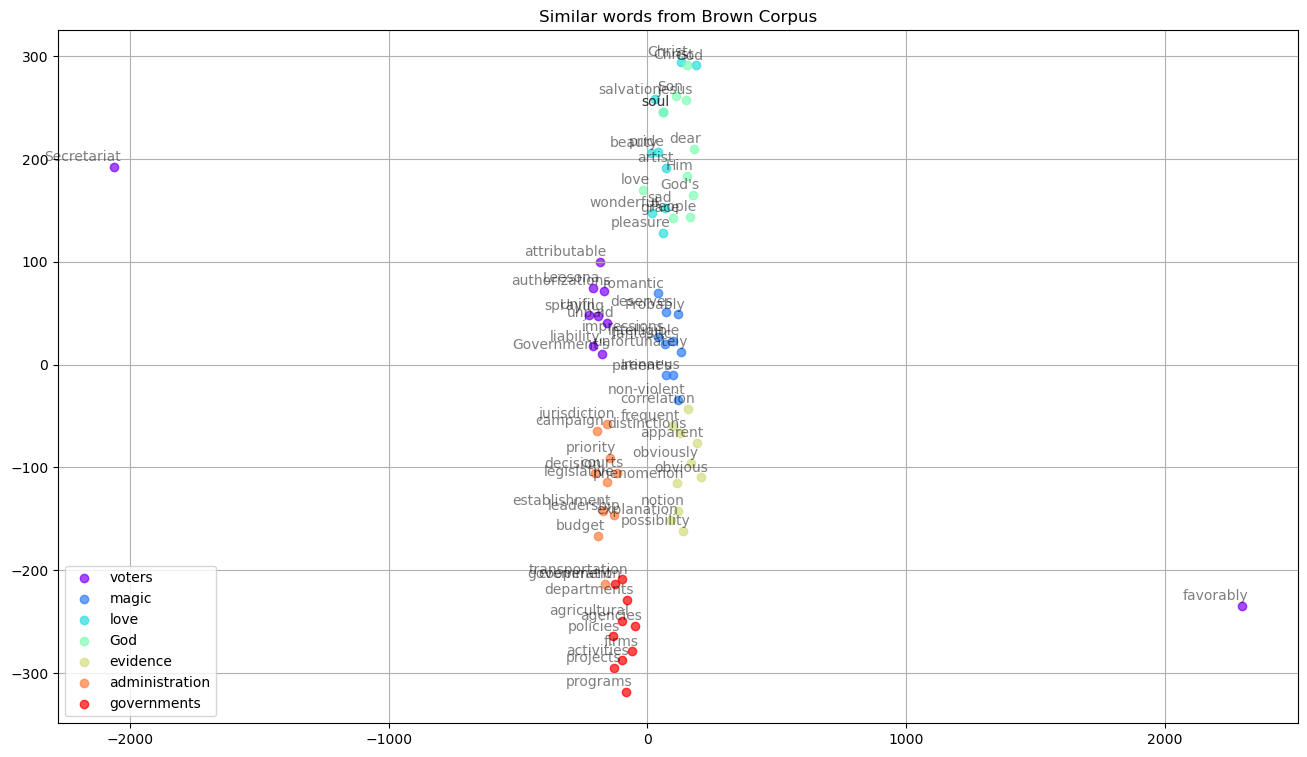

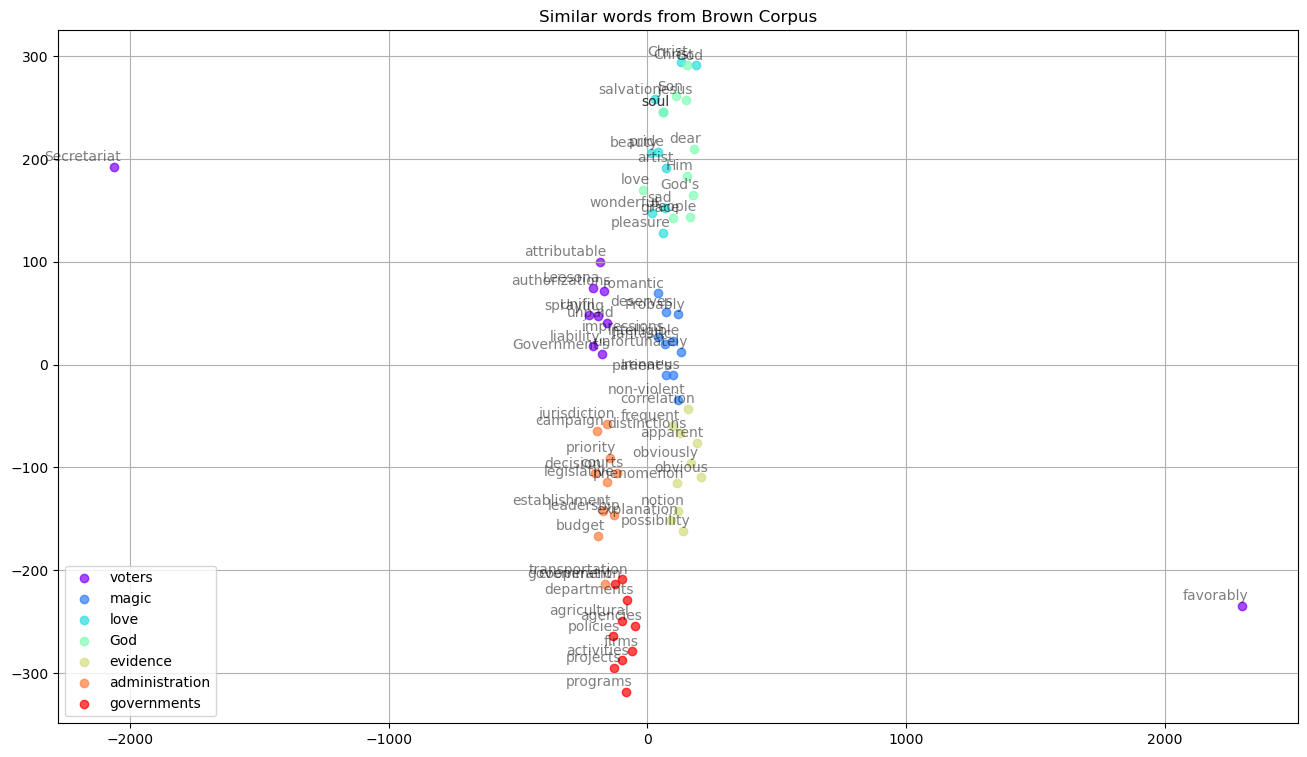

In [47]:
embeddings_en_2d, word_clusters = get_cluster_embeddings(keys)
tsne_plot_similar_words('Similar words from Brown Corpus', keys, embeddings_en_2d, word_clusters, 0.7)

## Exploring meaning

While word2vec was the method that started it all, research has since boomed, and we now have more sophisticated ways to represent words. One such method is FastText, developed at Facebook AI research, which breaks words into sub-words: such a technique also allows us to create embedding representations for unseen words. In this section, we will explore how semantics and meaning are captured using embedidngs, after downloading a pre-trained FastText model. Downloading pre-trained models is a way for us to plug in word embeddings and explore them without training them ourselves.

In [48]:
import os, io, zipfile
from urllib.request import urlopen

zipurl = 'https://osf.io/w9sr7/download'
print(f"Downloading and unzipping the file... Please wait.")
with urlopen(zipurl) as zipresp:
    with zipfile.ZipFile(io.BytesIO(zipresp.read())) as zfile:
        zfile.extractall('.')
print("Download completed!")

Download completed!


In [49]:
# Load 100 dimension FastText Vectors using FastText library
ft_en_vectors = fasttext.load_model('cc.en.100.bin')
print(f"Length of the embedding is: {len(ft_en_vectors.get_word_vector('king'))}")
print(f"Embedding for the word King is: {ft_en_vectors.get_word_vector('king')}")

Length of the embedding is: 100
Embedding for the word King is: [-0.04045481 -0.10617249 -0.27222311  0.06879666  0.16408321  0.00276707
  0.27080125 -0.05805573 -0.31865698  0.03748008 -0.00254088  0.13805169
 -0.00182498 -0.08973497  0.00319015 -0.19619396 -0.09858181 -0.10103802
 -0.08279888  0.0082208   0.13119364 -0.15956607  0.17203182  0.0315701
 -0.25064597  0.06182072  0.03929246  0.05157393  0.03543638  0.13660161
  0.05473648  0.06072914 -0.04709269  0.17394426 -0.02101276 -0.11402624
 -0.24489872 -0.08576579 -0.00322696 -0.04509873 -0.00614253 -0.05772085
 -0.073414   -0.06718913 -0.06057961  0.10963406  0.1245006  -0.04819863
  0.11408057  0.11081408  0.06752145 -0.01689911 -0.01186301 -0.11716368
 -0.01287614  0.10639337 -0.04243141  0.01057278 -0.0230855  -0.04930984
  0.04717607  0.03696446  0.0015999  -0.02193867 -0.01331578  0.11102925
  0.1686794   0.05814958 -0.00296521 -0.04252011 -0.00352389  0.06267346
 -0.07747819 -0.08959802 -0.02445797 -0.08913022  0.13422231 

In [50]:
ft_en_vectors.get_nearest_neighbors("king", 10)  # Most similar by key

[(0.8168574571609497, 'prince'),
 (0.796097457408905, 'emperor'),
 (0.7907207608222961, 'kings'),
 (0.7655220627784729, 'lord'),
 (0.7435404062271118, 'king-'),
 (0.7394551634788513, 'chieftain'),
 (0.7307553291320801, 'tyrant'),
 (0.7226710319519043, 'conqueror'),
 (0.719561755657196, 'kingly'),
 (0.718187689781189, 'queen')]

## Word Similarity

In [51]:
def getSimilarity(word1, word2):
    v1 = ft_en_vectors.get_word_vector(word1)
    v2 = ft_en_vectors.get_word_vector(word2)
    return cosine_similarity(v1, v2)

print("Similarity between the words King and Queen: ", getSimilarity("king", "queen"))
print("Similarity between the words King and Knight: ", getSimilarity("king", "knight"))
print("Similarity between the words King and Rock: ", getSimilarity("king", "rock"))
print("Similarity between the words King and Twenty: ", getSimilarity("king", "twenty"))

Similarity between the words King and Queen:  0.71818775
Similarity between the words King and Knight:  0.6881009
Similarity between the words King and Rock:  0.28928387
Similarity between the words King and Twenty:  0.19655468


# Neural Net with Word Embeddings

In [52]:
if 'ft_en_vectors' in locals():
    del ft_en_vectors
if 'w2vmodel' in locals():
    del w2vmodel

embedding_fasttext = FastText('simple')

.vector_cache/wiki.simple.vec: 293MB [00:18, 15.5MB/s]                              
100%|██████████| 111051/111051 [00:09<00:00, 11462.88it/s]


In [53]:
TEXT, vocab_size, train_iter, valid_iter, test_iter = load_dataset(embedding_fasttext, seed=SEED)

downloading aclImdb_v1.tar.gz


aclImdb_v1.tar.gz: 100%|██████████| 84.1M/84.1M [00:06<00:00, 12.6MB/s]


Data are loaded. sentence length: 50 seed: 2021


Define a vanilla neural network with linear layers. Then average the word embeddings to get an embedding for the entire review.
The neural net will have one hidden layer of size 128.

In [54]:
class NeuralNet(nn.Module):
    def __init__(self, output_size, hidden_size, vocab_size, embedding_length,
               word_embeddings):
        super(NeuralNet, self).__init__()

        self.word_embeddings = nn.Embedding(vocab_size, embedding_length)
        self.word_embeddings.weight = nn.Parameter(word_embeddings,
                                                   requires_grad=False)
        self.fc1 = nn.Linear(embedding_length, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, inputs):

        input = self.word_embeddings(inputs)  # convert text to embeddings
        # Average the word embeddings in a sentence
        # Use torch.nn.functional.avg_pool2d to compute the averages
        pooled = F.avg_pool2d(input, (input.shape[1], 1)).squeeze(1)

        # Pass the embeddings through the neural net
        # A fully-connected layer
        x = self.fc1(pooled)

        # ReLU activation
        x = F.relu(x)
        # Another fully-connected layer
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)

        return output

nn_model = NeuralNet(2, 128, 100, 300, TEXT.vocab.vectors)
print(nn_model)

NeuralNet(
  (word_embeddings): Embedding(100, 300)
  (fc1): Linear(in_features=300, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)


## Training and testing

In [55]:
def train(model, device, train_iter, valid_iter, epochs, learning_rate):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    train_loss, validation_loss = [], []
    train_acc, validation_acc = [], []

    for epoch in range(epochs):
        # train
        model.train()
        running_loss = 0.
        correct, total = 0, 0
        steps = 0

        for idx, batch in enumerate(train_iter):
            text = batch.text[0]
            target = batch.label
            target = torch.autograd.Variable(target).long()
            text, target = text.to(device), target.to(device)

            # add micro for coding training loop
            optimizer.zero_grad()
            output = model(text)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            steps += 1
            running_loss += loss.item()

            # get accuracy
            _, predicted = torch.max(output, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
        train_loss.append(running_loss/len(train_iter))
        train_acc.append(correct/total)

        print(f'Epoch: {epoch + 1}, '
              f'Training Loss: {running_loss/len(train_iter):.4f}, '
              f'Training Accuracy: {100*correct/total: .2f}%')

        # evaluate on validation data
        model.eval()
        running_loss = 0.
        correct, total = 0, 0

        with torch.no_grad():
            for idx, batch in enumerate(valid_iter):
                text = batch.text[0]
                target = batch.label
                target = torch.autograd.Variable(target).long()
                text, target = text.to(device), target.to(device)

                optimizer.zero_grad()
                output = model(text)

                loss = criterion(output, target)
                running_loss += loss.item()

                # get accuracy
                _, predicted = torch.max(output, 1)
                total += target.size(0)
                correct += (predicted == target).sum().item()

        validation_loss.append(running_loss/len(valid_iter))
        validation_acc.append(correct/total)

        print (f'Validation Loss: {running_loss/len(valid_iter):.4f}, '
               f'Validation Accuracy: {100*correct/total: .2f}%')

    return train_loss, train_acc, validation_loss, validation_acc


def test(model, device, test_iter):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for idx, batch in enumerate(test_iter):
            text = batch.text[0]
            target = batch.label
            target = torch.autograd.Variable(target).long()
            text, target = text.to(device), target.to(device)

            outputs = model(text)
            _, predicted = torch.max(outputs, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

        acc = 100 * correct / total
        return acc

In [56]:
# Model hyperparameters
learning_rate = 0.0003
output_size = 2
hidden_size = 128
embedding_length = 300
epochs = 15
word_embeddings = TEXT.vocab.vectors
vocab_size = len(TEXT.vocab)

# Model set-up
nn_model = NeuralNet(output_size,
                     hidden_size,
                     vocab_size,
                     embedding_length,
                     word_embeddings)
nn_model.to(DEVICE)
nn_start_time = time.time()
set_seed(522)
nn_train_loss, nn_train_acc, nn_validation_loss, nn_validation_acc = train(nn_model,
                                                                           DEVICE,
                                                                           train_iter,
                                                                           valid_iter,
                                                                           epochs,
                                                                           learning_rate)
print(f"--- Time taken to train = {(time.time() - nn_start_time)} seconds ---")
test_accuracy = test(nn_model, DEVICE, test_iter)
print(f'\n\nTest Accuracy: {test_accuracy}%')

Random seed 522 has been set.
Epoch: 1, Training Loss: 0.6658, Training Accuracy:  60.63%
Validation Loss: 0.6407, Validation Accuracy:  64.61%
Epoch: 2, Training Loss: 0.6230, Training Accuracy:  66.43%
Validation Loss: 0.6087, Validation Accuracy:  67.29%
Epoch: 3, Training Loss: 0.5980, Training Accuracy:  68.62%
Validation Loss: 0.5935, Validation Accuracy:  68.51%
Epoch: 4, Training Loss: 0.5870, Training Accuracy:  69.30%
Validation Loss: 0.5869, Validation Accuracy:  68.76%
Epoch: 5, Training Loss: 0.5815, Training Accuracy:  69.56%
Validation Loss: 0.5875, Validation Accuracy:  68.81%
Epoch: 6, Training Loss: 0.5771, Training Accuracy:  69.94%
Validation Loss: 0.5834, Validation Accuracy:  69.15%
Epoch: 7, Training Loss: 0.5738, Training Accuracy:  70.19%
Validation Loss: 0.5793, Validation Accuracy:  69.53%
Epoch: 8, Training Loss: 0.5721, Training Accuracy:  70.29%
Validation Loss: 0.6016, Validation Accuracy:  66.68%
Epoch: 9, Training Loss: 0.5707, Training Accuracy:  70.39

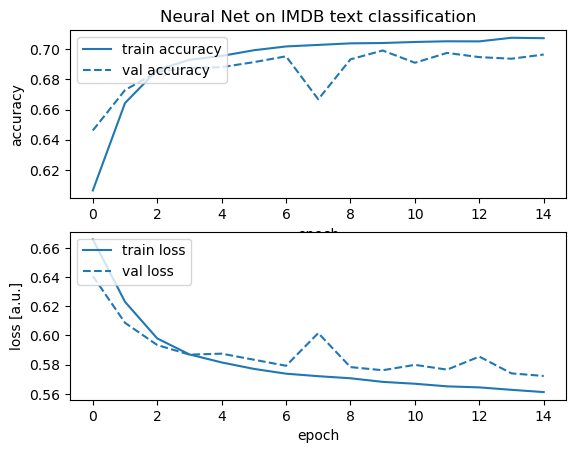

In [57]:
# Plot accuracy curves
plt.figure()
plt.subplot(211)
plot_train_val(np.arange(0, epochs), nn_train_acc, nn_validation_acc,
               'train accuracy', 'val accuracy',
               'Neural Net on IMDB text classification', 'accuracy',
               color='C0')
plt.legend(loc='upper left')
plt.subplot(212)
plot_train_val(np.arange(0, epochs), nn_train_loss,
               nn_validation_loss,
               'train loss', 'val loss',
               '',
               'loss [a.u.]',
               color='C0')
plt.legend(loc='upper left')
plt.show()

# Recurrent Neural Networks

When the recurrent network is trained to perform a task that requires predicting the future from the past, the network typically learns to use a hidden state at time step $t$, $H_t$ as a kind of lossy summary of the task-relevant aspects of the past sequence of inputs up to $t$. This summary is in general necessarily lossy, since it maps an arbitrary length sequence $(X_t, X_{t-1}, X_{t-2}, . . . , X_{2}, X_{1})$ to a ﬁxed length vector $H_t$.

We can represent the unfolded recurrence after $t$ steps with a function $G_t$:

\begin{align}
H_t &= G_t(X_t, X_{t-1}, X_{t-2}, \dots, X_{2}, X_{1}) \\
&= f(H_{t−1}, X_{t}; \theta)
\end{align}

where $\theta$ denotes the model parameters, i.e., weights and biases.

<figure>
  <img width=700 src="https://raw.githubusercontent.com/NeuromatchAcademy/course-content-dl/main/tutorials/W2D3_ModernRecurrentNeuralNetworks/static/rnn-2.gif">
  <figcaption>
  Source <a href="https://blog.floydhub.com/">blog.floydhub.com</a>
  </figcaption>
</figure>

The function $g_t$ takes the whole past sequence $(X_t, X_{t-1}, X_{t-2}, . . . , X_{2}, X_{1})$ as input and produces the current state, but the unfolded recurrent structure allows us to factorize $g_t$ into repeated application of a function f. The unfolding process thus introduces two major advantages:

* Regardless of the sequence length, the learned model always has the same input size, because it is speciﬁed in terms of transition from one state to another state, rather than speciﬁed in terms of a variable-length history of states.

* It is possible to use the same transition function $f$ with the same parameters at every time step.


We will now formally write down the equations of a recurrent unit.


Assume that we have a minibatch of inputs $X_t \in R^{nxd}$ at time step $t$ . In other words, for a minibatch of $n$ sequence examples, each row of $X_t$  corresponds to one example at time step $t$ from the sequence. Next, we denote by $H_t \in R^{nxh}$ the hidden variable of time step $t$. Unlike the MLP, here we save the hidden variable $H_{t-1}$ from the previous time step and introduce a new weight parameter $W_{hh} \in R^{hxh}$ to describe how to use the hidden variable of the previous time step in the current time step. Specifically, the calculation of the hidden variable of the current time step is determined by the input of the current time step together with the hidden variable of the previous time step:

\begin{equation}
H_t = \phi(X_t W_{xh} + H_{t-1}W_{hh} + b_h)
\end{equation}

For time step $t$, the output of the output layer is similar to the computation in the MLP:

\begin{equation}
O_t = H_t W_{hq} + b_q
\end{equation}
 
Parameters of the RNN include the weights $W_{xh} \in R^{d \times h}, W_{hh} \in R^{h \times h}$ , and the bias $b_h \in R^{1 \times h}$ of the hidden layer, together with the weights $W_{hq} \in R^{h \times  q}$ and the bias $b_q \in R^{1 \times q}$ of the output layer. It is worth mentioning that even at different time steps, RNNs always use these model parameters. Therefore, the parameterization cost of an RNN does not grow as the number of time steps increases.

<figure>
  <img width=700 align="center" src="https://raw.githubusercontent.com/NeuromatchAcademy/course-content-dl/main/tutorials/W2D3_ModernRecurrentNeuralNetworks/static/rnn.svg">
  <figcaption>
  Source <a href="https://d2l.ai/">d2l.ai</a>
  </figcaption>
</figure>

In [7]:
TEXT, vocab_size, train_iter, valid_iter, test_iter = load_dataset(seed=SEED)

Data loading is completed. Sentence length: 50, Batch size: 32, and seed: 2021


In [8]:
view_data(TEXT, train_iter)

Review:  elvira mistress of the dark is one of my fav movies , it has every thing you would want in a film , like great one liners , sexy star and a outrageous story ! if you have not seen it , you are missing out on one of the
Label:  1 

Review:  if you want scream or anything like the big-studio horror product that we get forced on us these days do n't bother . this well-written film kept me up thinking about all it had to say . importance of myth in our lives to make it make sense , how
Label:  1 

Review:  japanese tomo akiyama 's keko mask ( 1993 ) is extremely enjoyable trash film and so fun to watch ! there are also some sequels , but i have n't seen them since these films are hyper rare . some kind of re-releases some day would be nice since i
Label:  1 

Review:  i ca n't believe this show is still rating a 9 out of 10 . i could see if those votes were in the first 2 seasons , but what would possess anyone to continue to rate it high after that ? i was a huge fan the 1st seas

In [9]:
class VanillaRNN(nn.Module):
    def __init__(self, layers, output_size, hidden_size, vocab_size, embed_size,
               device):
        super(VanillaRNN, self).__init__()
        self.n_layers= layers
        self.hidden_size = hidden_size
        self.device = device
        # Define the embedding
        self.embeddings = nn.Embedding(vocab_size, embed_size)
        # Define the RNN layer
        self.rnn = nn.RNN(embed_size, hidden_size, self.n_layers)
        # Define the fully connected layer
        self.fc = nn.Linear(self.n_layers * hidden_size, output_size)

    def forward(self, inputs):
        input = self.embeddings(inputs)
        input = input.permute(1, 0, 2)
        h_0 = torch.zeros(2, input.size()[1], self.hidden_size).to(self.device)
        output, h_n = self.rnn(input, h_0)
        h_n = h_n.permute(1, 0, 2)
        h_n = h_n.contiguous().reshape(h_n.size()[0], h_n.size()[1]*h_n.size()[2])
        logits = self.fc(h_n)

        return logits

sampleRNN = VanillaRNN(2, 10, 50, 1000, 300, DEVICE)
print(sampleRNN)

VanillaRNN(
  (embeddings): Embedding(1000, 300)
  (rnn): RNN(300, 50, num_layers=2)
  (fc): Linear(in_features=100, out_features=10, bias=True)
)


Random seed 2021 has been set.
Epoch: 1, Training Loss: 0.6981, Training Accuracy:  50.98%
Validation Loss: 0.6959, Validation Accuracy:  50.37%
Epoch: 2, Training Loss: 0.6877, Training Accuracy:  54.07%
Validation Loss: 0.6954, Validation Accuracy:  51.45%
Epoch: 3, Training Loss: 0.6702, Training Accuracy:  58.61%
Validation Loss: 0.6665, Validation Accuracy:  60.80%
Epoch: 4, Training Loss: 0.6415, Training Accuracy:  63.50%
Validation Loss: 0.6585, Validation Accuracy:  61.91%
Epoch: 5, Training Loss: 0.6112, Training Accuracy:  67.22%
Validation Loss: 0.6556, Validation Accuracy:  63.41%
Epoch: 6, Training Loss: 0.5810, Training Accuracy:  70.06%
Validation Loss: 0.6529, Validation Accuracy:  65.71%
Epoch: 7, Training Loss: 0.5460, Training Accuracy:  73.29%
Validation Loss: 0.6360, Validation Accuracy:  67.21%
Epoch: 8, Training Loss: 0.5156, Training Accuracy:  75.46%
Validation Loss: 0.6343, Validation Accuracy:  66.61%
Epoch: 9, Training Loss: 0.4822, Training Accuracy:  77.9

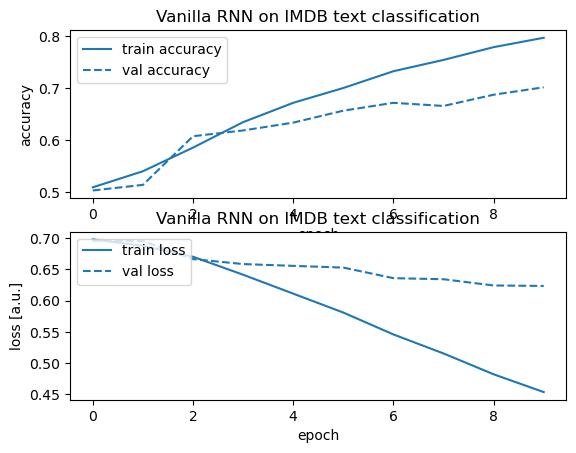

In [10]:
# Model hyperparamters
learning_rate = 0.0002
layers = 2
output_size = 2
hidden_size = 50  # 100
embedding_length = 100
epochs = 10


# Initialize model, training and testing
set_seed(SEED)
vanilla_rnn_model = VanillaRNN(layers, output_size, hidden_size, vocab_size,
                               embedding_length, DEVICE)
vanilla_rnn_model.to(DEVICE)
vanilla_rnn_start_time = time.time()
vanilla_train_loss, vanilla_train_acc, vanilla_validation_loss, vanilla_validation_acc = train(vanilla_rnn_model,
                                                                                               DEVICE,
                                                                                               train_iter,
                                                                                               valid_iter,
                                                                                               epochs,
                                                                                               learning_rate)
print("--- Time taken to train = %s seconds ---" % (time.time() - vanilla_rnn_start_time))
test_accuracy = test(vanilla_rnn_model, DEVICE, test_iter)
print(f'Test Accuracy: {test_accuracy} with len=50\n')

# Number of model parameters
print(f'Number of parameters = {count_parameters(vanilla_rnn_model)}')


# Plot accuracy curves
plt.figure()
plt.subplot(211)
plot_train_val(np.arange(0, epochs), vanilla_train_acc, vanilla_validation_acc,
               'train accuracy', 'val accuracy',
               'Vanilla RNN on IMDB text classification', 'accuracy',
               color='C0')
plt.legend(loc='upper left')
plt.subplot(212)
plot_train_val(np.arange(0, epochs), vanilla_train_loss,
               vanilla_validation_loss,
               'train loss', 'val loss',
               'Vanilla RNN on IMDB text classification',
               'loss [a.u.]',
               color='C0')
plt.legend(loc='upper left')
plt.show()

## Bidirectional RNNs

RNN models are mostly used in the fields of natural language processing and speech recognition. Below are types of RNNs. Depending on which outputs we use, RNN can be used for variety of tasks. The text classification problem we solved was an instance of the many to one architecture. Write down the applications of other architectures.

<figure>
  <img width=800 src="https://raw.githubusercontent.com/NeuromatchAcademy/course-content-dl/main/tutorials/W2D3_ModernRecurrentNeuralNetworks/static/karpathy.jpeg">
  <figcaption>
  Source <a href="https://blog.floydhub.com/">blog.floydhub.com</a>
  </figcaption>
</figure>

## Vanishing and Exploding Gradients

For an RNN to learn via backprop through time on a loss calculated at time $T$, $\mathcal{L}_T$, with respect to an input $t$ time steps in the past, the RNN weights must be updated based on how they contributed to the hidden state at this past time step. This contribution is learned through the term $\frac{\partial h_{-t}}{\partial W}$, in the gradient of the loss, $\frac{\partial\mathcal{L}_T}{\partial W}$.

However, because one has to backpropagate error through $t-1$ hidden states, $\frac{\partial h_{-t}}{\partial W}$ is multiplied by $\prod_{i=0}^{t-1} \frac{\partial{h_i}}{\partial{h_{i-1}}}$ in the expression for $\frac{\partial\mathcal{L}_T}{\partial W}$, which are summarized mathematically:

\begin{equation}
\frac{\partial{\mathcal{L}_T}}{\partial{W}} \propto \frac{\partial h_t }{ \partial W} + \sum_{k=0}^{t-1} \left( \prod_{i=k+1}^{t} \frac{\partial{h_i}}{\partial{h_{i-1}}} \right) \frac{\partial{h_k}}{\partial{W}}
\end{equation}

The product term leads to two common problems during the backpropagation of time-series data:

* *Vanishing gradients*, *if* $ \left| \left| \frac{\partial{h_i}}{\partial{h_{i-1}}} \right| \right|_2 < 1$


* *Exploding gradients*, *if* $ \left| \left| \frac{\partial{h_i}}{\partial{h_{i-1}}} \right| \right|_2 > 1$

Given a sufficiently long sequence, the gradients get multiplied by the weight matrix at every time step. If the weight matrix contains very small values, then the norm of gradients will become smaller and smaller exponentially, the so-called **vanishing gradient** problem. On the other hand, if we have a weight matrix with very large values, the gradients will increase exponentially, leading to the **exploding gradients** problem: where the weights diverge at the update step.

An example that has the vanishing gradient problem:

The input is the characters from a *C* Program. The system will tell whether it is a syntactically correct program. A syntactically correct program should have a valid number of braces and parentheses. Thus, the network should remember how many open parentheses and braces there are to check, and whether we have closed them all. The network has to store such information in hidden states like a counter. However, because of vanishing gradients, it will fail to preserve such information in a long program.

# LSTM, GRU, and Memory Cell

The core idea behind an LSTM is the cell state $C_t$ that runs along all the LSTM units in a layer, and gets updated along the way. These updates are possible through "gates". Gates are made out of a sigmoid neural net layer and a pointwise multiplication operation. 

Each LSTM unit performs the following distinct steps using the input $X_t$, current cell state $C_t$ and previous hidden state $H_{t-1}$:

* Forget Gate: *Should I throw away information from this cell?*

\begin{equation}
F_t = \sigma (W_f \cdot [H_{t-1}, X_t] + b_f)
\end{equation}

* Input Gate:
    * *Should I add new values to this cell?*
      \begin{equation}
      I_t = \sigma (W_i \cdot [H_{t-1}, X_t] + b_i)
      \end{equation}
    * *What new candidate values should I store?*
      \begin{equation}
      \tilde{C}_t = tanh (W_C \cdot [H_{t-1}, X_t] + b_C)
      \end{equation}

* Update cell state: *Forget things from the past and add new things from the candidates*
  \begin{equation}
  C_t = (F_t \cdot C_{t-1}) + (I_t \cdot \tilde{C}_t)
  \end{equation}

* Output Gate: 
    * *What information should I output?*
      \begin{equation}
      O_t = \sigma (W_o \cdot [H_{t-1}, X_t] + b_o)
      \end{equation}
    * *How much of the cell state should I store in the hidden state?*
      \begin{equation}
      H_t = O_t \cdot tanh(C_t)
      \end{equation}

The architecture can be summarized by the diagram below:

<center>
<figure>
  <img width=700 src="https://raw.githubusercontent.com/NeuromatchAcademy/course-content-dl/main/tutorials/W2D3_ModernRecurrentNeuralNetworks/static/lstm-1.svg">
  <figcaption>
  Source <a href="https://d2l.ai/">d2l.ai</a>
  </figcaption>
</figure>
</center>

In [11]:
class LSTM(nn.Module):
    def __init__(self, layers, output_size, hidden_size, vocab_size, embed_size,
               device):
        super(LSTM, self).__init__()
        self.n_layers = layers
        self.output_size = output_size
        self.hidden_size = hidden_size
        self.device = device
        # Define the word embeddings
        self.word_embeddings = nn.Embedding(vocab_size, embed_size)
        # Define the dropout layer
        self.dropout = nn.Dropout(0.5)
        # Define the lstm layer
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers=self.n_layers)
        # Define the fully-connected layer
        self.fc = nn.Linear(self.n_layers*self.hidden_size, output_size)


    def forward(self, input_sentences):
        """Hint: Make sure the shapes of your tensors match the requirement"""
        # Embeddings
        # `input` shape: (`num_steps`, `batch_size`, `num_hiddens`)
        input = self.word_embeddings(input_sentences).permute(1, 0, 2)

        hidden = (torch.randn(self.n_layers, input.shape[1],
                              self.hidden_size).to(self.device),
                  torch.randn(self.n_layers, input.shape[1],
                              self.hidden_size).to(self.device))
        # Dropout for regularization
        input = self.dropout(input)
        # LSTM
        output, hidden = self.lstm(input, hidden)

        h_n = hidden[0].permute(1, 0, 2)
        h_n = h_n.contiguous().view(h_n.shape[0], -1)

        logits = self.fc(h_n)

        return logits

sampleLSTM = LSTM(3, 10, 100, 1000, 300, DEVICE)
print(sampleLSTM)

LSTM(
  (word_embeddings): Embedding(1000, 300)
  (dropout): Dropout(p=0.5, inplace=False)
  (lstm): LSTM(300, 100, num_layers=3)
  (fc): Linear(in_features=300, out_features=10, bias=True)
)


Random seed 2021 has been set.
Epoch: 1, Training Loss: 0.6946, Training Accuracy:  50.26%
Validation Loss: 0.6938, Validation Accuracy:  50.41%
Epoch: 2, Training Loss: 0.6932, Training Accuracy:  51.33%
Validation Loss: 0.6930, Validation Accuracy:  50.47%
Epoch: 3, Training Loss: 0.6925, Training Accuracy:  51.53%
Validation Loss: 0.6924, Validation Accuracy:  51.71%
Epoch: 4, Training Loss: 0.6913, Training Accuracy:  52.29%
Validation Loss: 0.6911, Validation Accuracy:  52.27%
Epoch: 5, Training Loss: 0.6872, Training Accuracy:  54.36%
Validation Loss: 0.6739, Validation Accuracy:  58.71%
Epoch: 6, Training Loss: 0.6701, Training Accuracy:  59.26%
Validation Loss: 0.6628, Validation Accuracy:  61.56%
Epoch: 7, Training Loss: 0.6556, Training Accuracy:  61.73%
Validation Loss: 0.6451, Validation Accuracy:  63.56%
Epoch: 8, Training Loss: 0.6451, Training Accuracy:  63.22%
Validation Loss: 0.6330, Validation Accuracy:  65.41%
Epoch: 9, Training Loss: 0.6358, Training Accuracy:  64.2

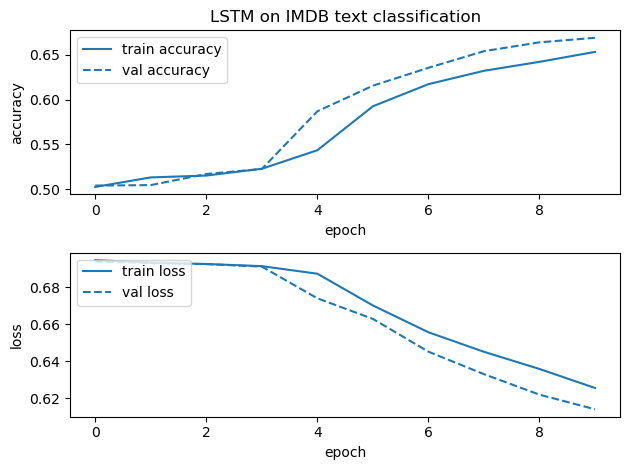

In [12]:
# Hyperparameters
learning_rate = 0.0003
layers = 2
output_size = 2
hidden_size = 16
embedding_length = 100
epochs = 10

# Model, training, testing
set_seed(SEED)
lstm_model = LSTM(layers, output_size, hidden_size, vocab_size,
                  embedding_length, DEVICE)
lstm_model.to(DEVICE)
lstm_train_loss, lstm_train_acc, lstm_validation_loss, lstm_validation_acc = train(lstm_model,
                                                                                   DEVICE,
                                                                                   train_iter,
                                                                                   valid_iter,
                                                                                   epochs,
                                                                                   learning_rate)
test_accuracy = test(lstm_model, DEVICE, test_iter)
print(f'\n\nTest Accuracy: {test_accuracy} of the LSTM model\n')

# Plotting accuracy curve
plt.figure()
plt.subplot(211)
plot_train_val(np.arange(0, epochs), lstm_train_acc, lstm_validation_acc,
               'train accuracy',
               'val accuracy',
               'LSTM on IMDB text classification',
               'accuracy',
               color='C0')
plt.legend(loc='upper left')
plt.subplot(212)
plot_train_val(np.arange(0, epochs), lstm_train_loss, lstm_validation_loss,
               'train loss',
               'val loss',
               '',
               'loss',
               color='C0')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

## Gated Recurrent Units (GRUs)

The GRU architecture looks very similar to the LSTM, and is often used as an alternative to the traditional LSTM. It also contains some variations that reduce it's complexity. For example, it combines the forget and input gates into a single “update gate”; it contains a "hidden state" but not a "cell state". In the next section we will be using GRUs as the choice of recurrent unit in our models, but you can always swap out the GRU for an LSTM later on (make sure that you take care of input and output dimensions in this case). Here is a description of the parts of the GRU:

* Reset Gate: *How much of the previous hidden state should I remember?*
  \begin{equation}
  R_t = \sigma (W_r \cdot [H_{t-1}, X_t])
  \end{equation}

* Update Gate: 
    * *How much of the new state is different from the old state?*
      \begin{equation}
      Z_t = \sigma (W_z \cdot [H_{t-1}, X_t])
      \end{equation}
    * *What new candidate values should I store?*
      \begin{equation}
      \tilde{H}_t = tanh (W \cdot [R_t \cdot H_{t-1}, X_t])
      \end{equation}

* Update hidden state: *Deciding how much of the old hidden state to keep and discard*
  \begin{equation}
  H_t = ((1-Z_t) \cdot H_{t-1} ) + (Z_t \cdot \tilde{H}_t)
  \end{equation}

Here is what the architecture looks like:

<center>
<figure>
  <img width=700 src="https://raw.githubusercontent.com/NeuromatchAcademy/course-content-dl/main/tutorials/W2D3_ModernRecurrentNeuralNetworks/static/gru-3.svg">
  <figcaption>
  Source <a href="https://d2l.ai/">d2l.ai</a>
  </figcaption>
</figure>
</center>

In [13]:
class biLSTM(nn.Module):
    def __init__(self, output_size, hidden_size, vocab_size, embed_size,
               device):
        super(biLSTM, self).__init__()
        self.output_size = output_size
        self.hidden_size = hidden_size
        self.device = device
        # Define the word embeddings
        self.word_embeddings = nn.Embedding(vocab_size, embed_size)
        # Define the dropout layer
        self.dropout = nn.Dropout(0.5)
        # Define the bilstm layer
        self.bilstm = nn.LSTM(embed_size, hidden_size, num_layers=2, bidirectional=True)
        # Define the fully-connected layer
        self.fc = nn.Linear(4*hidden_size, output_size)

    def forward(self, input_sentences):
        input = self.word_embeddings(input_sentences).permute(1, 0, 2)
        hidden = (torch.randn(4, input.shape[1], self.hidden_size).to(self.device),
                  torch.randn(4, input.shape[1], self.hidden_size).to(self.device))
        input = self.dropout(input)

        output, hidden = self.bilstm(input, hidden)

        h_n = hidden[0].permute(1, 0, 2)
        h_n = h_n.contiguous().view(h_n.shape[0], -1)
        logits = self.fc(h_n)

        return logits

sampleBiLSTM = biLSTM(10, 100, 1000, 300, DEVICE)
print(sampleBiLSTM)

biLSTM(
  (word_embeddings): Embedding(1000, 300)
  (dropout): Dropout(p=0.5, inplace=False)
  (bilstm): LSTM(300, 100, num_layers=2, bidirectional=True)
  (fc): Linear(in_features=400, out_features=10, bias=True)
)


Random seed 2021 has been set.
Epoch: 1, Training Loss: 0.6938, Training Accuracy:  51.12%
Validation Loss: 0.6905, Validation Accuracy:  52.68%
Epoch: 2, Training Loss: 0.6912, Training Accuracy:  52.47%
Validation Loss: 0.6874, Validation Accuracy:  54.03%
Epoch: 3, Training Loss: 0.6885, Training Accuracy:  53.90%
Validation Loss: 0.6815, Validation Accuracy:  56.47%
Epoch: 4, Training Loss: 0.6739, Training Accuracy:  58.59%
Validation Loss: 0.6540, Validation Accuracy:  61.59%
Epoch: 5, Training Loss: 0.6555, Training Accuracy:  60.97%
Validation Loss: 0.6345, Validation Accuracy:  64.35%
Epoch: 6, Training Loss: 0.6378, Training Accuracy:  63.46%
Validation Loss: 0.6159, Validation Accuracy:  66.09%
Epoch: 7, Training Loss: 0.6214, Training Accuracy:  65.88%
Validation Loss: 0.6016, Validation Accuracy:  67.12%
Epoch: 8, Training Loss: 0.6058, Training Accuracy:  67.24%
Validation Loss: 0.5899, Validation Accuracy:  68.64%
Epoch: 9, Training Loss: 0.5942, Training Accuracy:  68.1

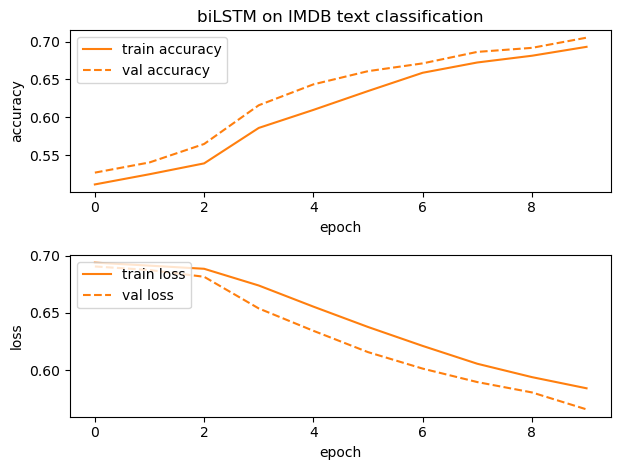

In [14]:
# Hyperparameters
learning_rate = 0.0003
output_size = 2
hidden_size = 16
embedding_length = 100
epochs = 10

# Model, training, testing
set_seed(SEED)
bilstm_model = biLSTM(output_size, hidden_size, vocab_size,
                      embedding_length, DEVICE)
bilstm_model.to(DEVICE)
bilstm_train_loss, bilstm_train_acc, bilstm_validation_loss, bilstm_validation_acc = train(bilstm_model,
                                                                                           DEVICE,
                                                                                           train_iter,
                                                                                           valid_iter,
                                                                                           epochs,
                                                                                           learning_rate)
test_accuracy = test(bilstm_model, DEVICE, test_iter)
print(f'Test Accuracy: {test_accuracy} of the biLSTM model\n')

# Plotting accuracy curve
plt.figure()
plt.subplot(211)
plot_train_val(np.arange(0, epochs), bilstm_train_acc, bilstm_validation_acc,
               'train accuracy',
               'val accuracy',
               'biLSTM on IMDB text classification',
               'accuracy',
               color='C1')
plt.legend(loc='upper left')
plt.subplot(212)
plot_train_val(np.arange(0, epochs), bilstm_train_loss, bilstm_validation_loss,
               'train loss',
               'val loss',
               '',
               'loss',
               color='C1')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

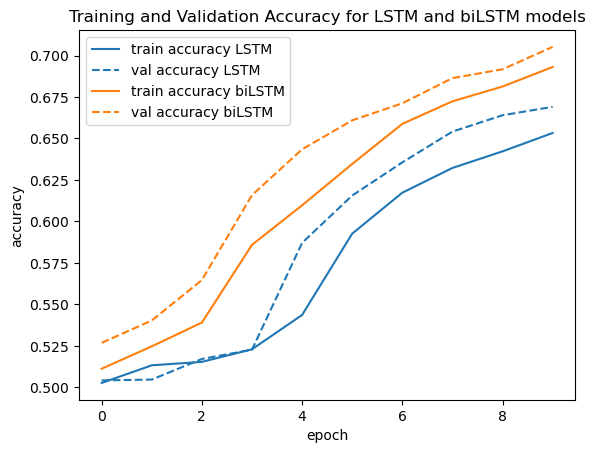

In [15]:
# Compare accuracies of LSTM and biLSTM
plot_train_val(np.arange(0, epochs), lstm_train_acc,
               lstm_validation_acc,
               'train accuracy LSTM', 'val accuracy LSTM',
               '', 'accuracy',
               color='C0')
plot_train_val(np.arange(0, epochs), bilstm_train_acc,
               bilstm_validation_acc,
               'train accuracy biLSTM', 'val accuracy biLSTM',
               'Training and Validation Accuracy for LSTM and biLSTM models',
               'accuracy',
               color='C1')
plt.legend(loc='upper left')
plt.show()

# Sequence to Sequence and Encoder/Decoder Models

Sequence-to-sequence models take in a sequence of items (words, characters, etc) as input and produces another sequence of items as output. The most 
simple seq2seq models are composed of two parts: the encoder, the context ("state" in the figure) and the decoder. The encoder and decoder usually consist of recurrent units that we've seen before (RNNs, GRUs or LSTMs). A high-level schematic of the architecture is as follows:

<center>
<figure>
  <img width=700 src="https://raw.githubusercontent.com/NeuromatchAcademy/course-content-dl/main/tutorials/W2D3_ModernRecurrentNeuralNetworks/static/seq2seq-predict.svg">
  <figcaption>
  Source <a href="https://d2l.ai/">d2l.ai</a>
  </figcaption>
</figure>
</center>

The encoder's recurrent unit processes the input one item at a time. Once the entire sequence is processed, the final hidden state vector produced is known as a context vector. The size of the context vector is defined while setting up the model, and is equal to the number of hidden states used in the encoder RNN. The encoder then passes the context to the decoder. The decoder's recurrent unit uses the context to produce the items for the output sequence one by one. 

One of the most popular applications of seq2seq models is "machine translation": the task of taking in a sentence in one language (the source) and producing its translation in another language (the target); with words in both lanugages being the sequence units. This is a supervised learning task, and requires the dataset to have "parallel sentences"; i.e., each sentence in the source language must be labelled with its translation in the target language. 

[Here is an intuitive visualization for understanding seq2seq models for machine translation from English to French](https://i.imgur.com/HJ6t8up.mp4)

Since the vocabulary of an entire language is very large, training such models to give meaningful performance requires significant time and resources. In this section, we will train a seq2seq model to perform machine translation from English to [Pig-Latin](https://en.wikipedia.org/wiki/Pig_Latin). We will modify the task to perform character-level machine translation, so that vocabulary size does not grow exponentially.  

## Encoder

Let us consider a sequence example (`batch_size=1`). Suppose that the input sequence is $x_1, \ldots, x_T$, such that $x_t$ is the $t^{\mathrm{th}}$ token in the input text sequence. At time step $t$, the RNN transforms the input feature vector $\mathbf{x}_t$ for $x_t$ and the hidden state $\mathbf{h} _{t-1}$ from the previous time step into the current hidden state $\mathbf{h}_t$.

We can use a function $f$ to express the transformation of the RNN's recurrent layer:

\begin{equation}
\mathbf{h}_t = f(\mathbf{x}_t, \mathbf{h}_{t-1})
\end{equation}

In general, the encoder transforms the hidden states at all the time steps into the context variable through a customized function $q$:

\begin{equation}
\mathbf{c} =  q(\mathbf{h}_1, \ldots, \mathbf{h}_T)
\end{equation}

For example, when choosing $q(\mathbf{h}_1, \ldots, \mathbf{h}_T) = \mathbf{h}_T$  the context variable is just the hidden state $\mathbf{h}_T$ of the input sequence at the final time step.

So far we have used a unidirectional RNN to design the encoder, where a hidden state only depends on the input subsequence at and before the time step of the hidden state. We can also construct encoders using bidirectional RNNs. In this case, a hidden state depends on the subsequence before and after the time step (including the input at the current time step), which encodes the information of the entire sequence.

Now let us implement the RNN encoder. Note that we use an *embedding layer*
to obtain the feature vector for each token in the input sequence. The weight of an embedding layer is a matrix whose number of rows is equal to the size of the input vocabulary (`vocab_size`) and the number of columns equals to the feature vector's dimension (`embed_size`). For any input token index $i$,
the embedding layer fetches the $i^{\mathrm{th}}$ row (starting from 0) of the weight matrix to return its feature vector. ere we choose a multilayer GRU to implement the encoder.

The returned variables of recurrent layers have been completely explained at [this link](https://www.d2l.ai/chapter_recurrent-neural-networks/rnn-concise.html#sec-rnn-concise). Let us still use a concrete example to illustrate the above encoder implementation. Below we instantiate a two-layer GRU encoder whose number of hidden units is 16. Given a minibatch of sequence inputs $X$ (`batch_size=4`, `number_of_time_steps=7`), the hidden states of the last layer at all the time steps (`output` returned by the encoder's recurrent layers) are a tensor of shape (number of time steps, batch size, number of hidden units).

In [18]:
class Seq2SeqEncoder(d2l.Encoder):
    """The RNN encoder for sequence to sequence learning."""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                dropout=0, **kwargs):
        super(Seq2SeqEncoder, self).__init__(**kwargs)

        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embed_size)
        # Here you're going to implement a GRU as the RNN unit
        self.rnn = nn.GRU(embed_size, num_hiddens, num_layers,
                          dropout=dropout)

    def forward(self, X, *args):
        # The output `X` shape: (`batch_size`, `num_steps`, `embed_size`)
        X = self.embedding(X)
        # In RNN models, the first axis corresponds to time steps
        X = X.permute(1, 0, 2)
        # When state is not mentioned, it defaults to zeros, the output should be a RNN function of X!
        output, state = self.rnn(X)
        # `output` shape: (`num_steps`, `batch_size`, `num_hiddens`)
        # `state` shape: (`num_layers`, `batch_size`, `num_hiddens`)
        return output, state

X = torch.zeros((4, 7), dtype=torch.long)
encoder = Seq2SeqEncoder(vocab_size=10, embed_size=8, num_hiddens=16, num_layers=2)
encoder.eval()
output, state = encoder(X)
print(output.shape)
print(state.shape)

torch.Size([7, 4, 16])
torch.Size([2, 4, 16])


## Decoder

As we just mentioned, the context variable $\mathbf{c}$ of the encoder's output encodes the entire input sequence $x_1, \ldots, x_T$. Given the output sequence $y_1, y_2, \ldots, y_{T'}$ from the training dataset, for each time step $t'$
(the symbol differs from the time step $t$ of input sequences or encoders),
the probability of the decoder output $y_{t'}$ is conditional on the previous output subsequence $y_1, \ldots, y_{t'-1}$ and the context variable $\mathbf{c}$, i.e., $P(y_{t'} \mid y_1, \ldots, y_{t'-1}, \mathbf{c})$.


To model this conditional probability on sequences, we can use another RNN as the decoder. At any time step $t^\prime$ on the output sequence, the RNN takes the output $y_{t^\prime-1}$ from the previous time step and the context variable $\mathbf{c}$ as its input, then transforms them and the previous hidden state $\mathbf{s}_{t^\prime-1}$ into the hidden state $\mathbf{s}_{t^\prime}$ at the current time step.

As a result, we can use a function $g$ to express the transformation of the decoder's hidden layer:

\begin{equation}
\mathbf{s}_{t^\prime} = g(y_{t^\prime-1}, \mathbf{c}, \mathbf{s}_{t^\prime-1})
\end{equation}

After obtaining the hidden state of the decoder, we can use an output layer and the softmax operation to compute the conditional probability distribution
$P(y_{t^\prime} \mid y_1, \ldots, y_{t^\prime-1}, \mathbf{c})$ for the output at time step $t^\prime$.

Following `fig_seq2seq`, when implementing the decoder as follows, we directly use the hidden state at the final time step of the encoder to initialize the hidden state of the decoder.

This requires that the RNN encoder and the RNN decoder have the same number of layers and hidden units. To further incorporate the encoded input sequence information, the context variable is concatenated with the decoder input at all the time steps. To predict the probability distribution of the output token,
a fully-connected layer is used to transform the hidden state at the final layer of the RNN decoder.

In [20]:
class Seq2SeqDecoder(d2l.Decoder):
    """The RNN decoder for sequence to sequence learning."""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                dropout=0, **kwargs):
        super(Seq2SeqDecoder, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(embed_size + num_hiddens, num_hiddens, num_layers,
                          dropout=dropout)
        self.dense = nn.Linear(num_hiddens, vocab_size)

    def init_state(self, enc_outputs, *args):
        return enc_outputs[1]

    def forward(self, X, state):
        # The output `X` shape: (`num_steps`, `batch_size`, `embed_size`)
        X = self.embedding(X).permute(1, 0, 2)
        # Broadcast `context` so it has the same `num_steps` as `X`
        context = state[-1].repeat(X.shape[0], 1, 1)
        X_and_context = torch.cat((X, context), 2)
        output, state = self.rnn(X_and_context, state)
        output = self.dense(output).permute(1, 0, 2)
        # `output` shape: (`batch_size`, `num_steps`, `vocab_size`)
        # `state` shape: (`num_layers`, `batch_size`, `num_hiddens`)
        return output, state

In [21]:
decoder = Seq2SeqDecoder(vocab_size=10, embed_size=8, num_hiddens=16,
                         num_layers=2)
# decoder.initialize()
state = decoder.init_state(encoder(X))
output, state = decoder(X, state)
output.shape, len(state), state[0].shape

(torch.Size([4, 7, 10]), 2, torch.Size([4, 16]))

## Loss Function

At each time step, the decoder predicts a probability distribution for the output tokens. Similar to language modeling, we can apply softmax to obtain the distribution and calculate the cross-entropy loss for optimization. Recall that the special padding tokens are appended to the end of sequences so sequences of varying lengths can be efficiently loaded in minibatches of the same shape.
However, prediction of padding tokens should be excluded from loss calculations.

To this end, we can use the following `sequence_mask` function to mask irrelevant entries with zero values so later multiplication of any irrelevant prediction with zero equals to zero. For example, if the valid length of two sequences excluding padding tokens (i.e., pads each sequence to the same length usually matching the longest sequence) are one and two, respectively, the remaining entries after the first one and the first two entries are cleared to zeros.

In [22]:
def sequence_mask(X, valid_len, value=0):
    """Mask irrelevant entries in sequences."""
    maxlen = X.size(1)
    mask = torch.arange((maxlen), dtype=torch.float32,
                      device=X.device)[None, :] < valid_len[:, None]
    X[~mask] = value
    return X


X = torch.tensor([[1, 2, 3], [4, 5, 6]])
print(sequence_mask(X, torch.tensor([1, 2])))
X = torch.ones(2, 3, 4)
print(sequence_mask(X, torch.tensor([1, 2]), value=-1))

tensor([[1, 0, 0],
        [4, 5, 0]])
tensor([[[ 1.,  1.,  1.,  1.],
         [-1., -1., -1., -1.],
         [-1., -1., -1., -1.]],

        [[ 1.,  1.,  1.,  1.],
         [ 1.,  1.,  1.,  1.],
         [-1., -1., -1., -1.]]])


Now we can extend the softmax cross-entropy loss
to allow the masking of irrelevant predictions.
Initially,
masks for all the predicted tokens are set to one.
Once the valid length is given,
the mask corresponding to any padding token
will be cleared to zero.
In the end,
the loss for all the tokens
will be multipled by the mask to filter out
irrelevant predictions of padding tokens in the loss.

In [23]:
class MaskedSoftmaxCELoss(nn.CrossEntropyLoss):
    """The softmax cross-entropy loss with masks."""

  # `pred` shape: (`batch_size`, `num_steps`, `vocab_size`)
  # `label` shape: (`batch_size`, `num_steps`)
  # `valid_len` shape: (`batch_size`,)

    def forward(self, pred, label, valid_len):
        weights = torch.ones_like(label)
        weights = sequence_mask(weights, valid_len)
        self.reduction = 'none'
        unweighted_loss = super(MaskedSoftmaxCELoss,
                                self).forward(pred.permute(0, 2, 1), label)
        weighted_loss = (unweighted_loss * weights).mean(dim=1)

        return weighted_loss


loss = MaskedSoftmaxCELoss()
loss(torch.ones(3, 4, 10),
     torch.ones((3, 4), dtype=torch.long),
     torch.tensor([4, 2, 0]))

tensor([2.3026, 1.1513, 0.0000])

## Training & Prediction

In the following training loop,
we concatenate the special beginning-of-sequence token
and the original output sequence excluding the final token as
the input to the decoder.
This is called *teacher forcing* because
the original output sequence (token labels) is fed into the decoder.
Alternatively,
we could also feed the *predicted* token
from the previous time step
as the current input to the decoder.

In [24]:
def train_seq2seq(net, data_iter, lr, num_epochs, tgt_vocab, device):
    """Train a model for sequence to sequence."""
    def xavier_init_weights(m):
        if type(m) == nn.Linear:
            nn.init.xavier_uniform_(m.weight)
        if type(m) == nn.GRU:
            for param in m._flat_weights_names:
                if "weight" in param:
                    nn.init.xavier_uniform_(m._parameters[param])


    net.apply(xavier_init_weights)
    net.to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    loss = MaskedSoftmaxCELoss()
    net.train()
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                          xlim=[10, num_epochs])
    for epoch in range(num_epochs):
        timer = d2l.Timer()
        metric = d2l.Accumulator(2)  # Sum of training loss, no. of tokens
        for batch in data_iter:
            optimizer.zero_grad()
            X, X_valid_len, Y, Y_valid_len = [x.to(device) for x in batch]
            bos = torch.tensor([tgt_vocab['<bos>']] * Y.shape[0],
                              device=device).reshape(-1, 1)
            dec_input = torch.cat([bos, Y[:, :-1]], 1)  # Teacher forcing
            Y_hat, _ = net(X, dec_input, X_valid_len)
            l = loss(Y_hat, Y, Y_valid_len)
            l.sum().backward()  # Make the loss scalar for `backward`
            d2l.grad_clipping(net, 1)
            num_tokens = Y_valid_len.sum()
            optimizer.step()
            with torch.no_grad():
                metric.add(l.sum(), num_tokens)
        if (epoch + 1) % 10 == 0:
            animator.add(epoch + 1, (metric[0] / metric[1],))
    print(f'loss {metric[0] / metric[1]:.3f}, {metric[1] / timer.stop():.1f} '
        f'tokens/sec on {str(device)}')

In [25]:
embed_size, num_hiddens, num_layers, dropout = 32, 32, 2, 0.1
batch_size, num_steps = 64, 10
lr, num_epochs = 0.005, 300

train_iter, src_vocab, tgt_vocab = d2l.load_data_nmt(batch_size, num_steps)
encoder = Seq2SeqEncoder(len(src_vocab), embed_size, num_hiddens, num_layers,
                         dropout)
decoder = Seq2SeqDecoder(len(tgt_vocab), embed_size, num_hiddens, num_layers,
                         dropout)
net = d2l.EncoderDecoder(encoder, decoder)
train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, DEVICE)

loss 0.019, 6150.4 tokens/sec on cpu


To predict the output sequence token by token, at each decoder time step
the predicted token from the previous time step is fed into the decoder as an input.

Similar to training, at the initial time step the beginning-of-sequence (&lt;bos&gt;") token is fed into the decoder. This prediction process is illustrated in `seq2seq` figure. When the end-of-sequence ("&lt;eos&gt;") token is predicted, the prediction of the output sequence is complete.


<figure>
  <img src="https://raw.githubusercontent.com/NeuromatchAcademy/course-content-dl/main/tutorials/W2D3_ModernRecurrentNeuralNetworks/static/seq2seq-predict.svg">
  <figcaption>
  Source <a href="https://d2l.ai/">d2l.ai</a>
  </figcaption>
</figure>

In [26]:
def predict_seq2seq(net, src_sentence, src_vocab, tgt_vocab, num_steps,
                    device, save_attention_weights=False):
    """Predict for sequence to sequence."""
    # Set `net` to eval mode for inference
    net.eval()
    src_tokens = src_vocab[src_sentence.lower().split(' ')] + [
      src_vocab['<eos>']]
    enc_valid_len = torch.tensor([len(src_tokens)], device=device)
    src_tokens = d2l.truncate_pad(src_tokens, num_steps, src_vocab['<pad>'])
    # Add the batch axis
    enc_X = torch.unsqueeze(
      torch.tensor(src_tokens, dtype=torch.long, device=device), dim=0)
    enc_outputs = net.encoder(enc_X, enc_valid_len)
    dec_state = net.decoder.init_state(enc_outputs, enc_valid_len)
    # Add the batch axis
    dec_X = torch.unsqueeze(
      torch.tensor([tgt_vocab['<bos>']], dtype=torch.long, device=device),
      dim=0)
    output_seq, attention_weight_seq = [], []
    for _ in range(num_steps):
        Y, dec_state = net.decoder(dec_X, dec_state)
        # We use the token with the highest prediction likelihood as the input
        # of the decoder at the next time step
        dec_X = Y.argmax(dim=2)
        pred = dec_X.squeeze(dim=0).type(torch.int32).item()
        # Save attention weights (to be covered later)
        if save_attention_weights:
            attention_weight_seq.append(net.decoder.attention_weights)
        # Once the end-of-sequence token is predicted, the generation of the
        # output sequence is complete
        if pred == tgt_vocab['<eos>']:
            break
        output_seq.append(pred)
    return ' '.join(tgt_vocab.to_tokens(output_seq)), attention_weight_seq

## Evaluation

We can evaluate a predicted sequence by comparing it with the label sequence (the ground-truth). BLEU (Bilingual Evaluation Understudy), though originally proposed for evaluating machine translation results in [Papieni et al., 2002](https://dl.acm.org/doi/10.3115/1073083.1073135), has been extensively used in measuring the quality of output sequences for different applications.

In principle, for any $n$-grams in the predicted sequence, BLEU evaluates whether this $n$-grams appears in the label sequence.

Denote by $p_n$ the precision of $n$-grams, which is the ratio of the number of matched $n$-grams in the predicted and label sequences to the number of $n$-grams in the predicted sequence.
To explain, given a label sequence $A$, $B$, $C$, $D$, $E$, $F$, and a predicted sequence $A$, $B$, $B$, $C$, $D$, we have $p_1 = 4/5$,  $p_2 = 3/4$, $p_3 = 1/3$, and $p_4 = 0$.

Besides, let $\mathrm{len}_{\text{label}}$ and $\mathrm{len}_{\text{pred}}$
be the numbers of tokens in the label sequence and the predicted sequence, respectively.

Then, BLEU is defined as

\begin{equation}
\exp\left(\min\left(0, 1 - \frac{\mathrm{len}_{\text{label}}}{\mathrm{len}_{\text{pred}}}\right)\right) \prod_{n=1}^k p_n^{1/2^n},
\end{equation}

where $k$ is the longest $n$-grams for matching.

Based on the definition of BLEU in the above equation, whenever the predicted sequence is the same as the label sequence, BLEU is 1.

Moreover, since matching longer $n$-grams is more difficult, BLEU assigns a greater weight to a longer $n$-gram precision. Specifically, when $p_n$ is fixed, $p_n^{1/2^n}$ increases as $n$ grows (the original paper uses $p_n^{1/n}$).

Furthermore, since predicting shorter sequences tends to obtain a higher $p_n$ value, the coefficient before the multiplication term in the above equation
penalizes shorter predicted sequences.

For example, when $k=2$, given the label sequence $A$, $B$, $C$, $D$, $E$, $F$ and the predicted sequence $A$, $B$, although $p_1 = p_2 = 1$, the penalty factor $\exp(1-6/2) \approx 0.14$ lowers the BLEU.

We implement the BLEU measure as follows.

In [32]:
def bleu(pred_seq, label_seq, k):
    """Compute the BLEU."""
    pred_tokens, label_tokens = pred_seq.split(' '), label_seq.split(' ')
    len_pred, len_label = len(pred_tokens), len(label_tokens)
    score = math.exp(min(0, 1 - len_label / len_pred))
    for n in range(1, k + 1):
        num_matches, label_subs = 0, collections.defaultdict(int)
        for i in range(len_label - n + 1):
            label_subs[''.join(label_tokens[i:i + n])] += 1
        for i in range(len_pred - n + 1):
            if label_subs[''.join(pred_tokens[i:i + n])] > 0:
                num_matches += 1
                label_subs[''.join(pred_tokens[i:i + n])] -= 1
        score *= math.pow(num_matches / (len_pred - n + 1), math.pow(0.5, n))
    return score

In [33]:
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
# fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
fras = [ 'je suis chez moi .', 'j\'ai perdu .','va !', 'il est calme .']
for eng, fra in zip(engs, fras):
    translation, attention_weight_seq = predict_seq2seq(net,
                                                      eng,
                                                      src_vocab,
                                                      tgt_vocab,
                                                      num_steps,
                                                      DEVICE)
    print(f'{eng} => {translation}, bleu {bleu(translation, fra, k=2):.3f}')

go . => va !, bleu 0.000
i lost . => j'ai <unk> pas <unk> ., bleu 0.000
he's calm . => il est <unk> ., bleu 0.000
i'm home . => je suis <unk> bien <unk> ., bleu 0.000
